# Business Understanding

The problem for this project is to determine the severity of car crashes on a certain day based on various weather and road conditions. This has many business applications from healthcare systems (having more emergency medical technicians EMTs on call) to a company based on this concept to warn users to be careful on the road when high severity crashes are more likely. 

For the duration of the project we will the goal of this model is to provide a healthcare system information on the predicted severity of vehicle collisions so that they can appropriately designate EMTs and ER resources to deal with the approriate levels of demand.

This is very valuable for hospitals to be able to understand these trends from financial and philanthropic perspectives. Hospitals are also businesses and to be able to optimize their staff for low severity days allows the hospital to spend less money which can work towards the benefit of other systems within the hospital. From a philanthropic perspective providing more staff on high severity days will reduce the amount of injuries which escalate in severity due to lack of efficient or timely care. 

In a more complicated system this type of prediction could help Ambulances avoid high crash severity areas when delivering patients. 

# DATA

To understand and address the need for prediction of vehicle collision severity based on weather conditions we need to find the appropriate data. The IBM Data Science course has a provided us with shared data to as an example but also recommends we look for other data sources. 

We would like to had data features such as, road conditions, lighting, and weather.

I've collected data from [data.gov](data.gov) for ny vehicle collisions as well as weather data from [NOAA](https://www.ncdc.noaa.gov/). I'll be combining these two data sources to understand the weather conditions on the days of a crash so that we can predicte severity based on that. I'll compare this combined datasource against the IBM datasource to ensure we have enough quality data to create a model with our derived data. If not we'll go with the IBM Shared data.

[Documentation for NOAA data](https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf)

**I have done the work for my collected data in a previous notebook. After cleaning and balancing the data I noticed that there was little to no correlation with crash severity or frequency. I believe that this is moreso to do with the quality and quantity of the data rather than a lack of correlation. Thus I need to go and collect more data, in the interest of time I'll be using the GISWEB Collision data that IBM's DATA SCIENCE course has pointed me to.**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
df = pd.read_csv("data/Data-Collisions.csv")
df.head()

C:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [72]:
df.SEVERITYCODE.value_counts() # Check for data balance

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

In [73]:
def undersample(df, feature):
    df_0 = df[df.SEVERITYCODE == 1]
    df_1 = df[df.SEVERITYCODE == 2]

    df_0_undersample = df_0.sample(df[feature].value_counts()[2])

    return pd.concat([df_0_undersample, df_1], axis=0)

In [74]:
df_balanced = undersample(df, 'SEVERITYCODE')
df_balanced.SEVERITYCODE.value_counts()

2    58188
1    58188
Name: SEVERITYCODE, dtype: int64

### Start by doing exploratory data analysis on features we'd expect to predict crash severity.

Starting with The Address Type. This feature is very valuable for both an individual seeking to avoid high severity crash locations as well as positioning EMTs in high risk locations on high risk days. 

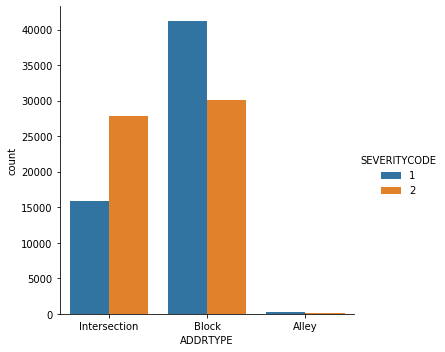

In [6]:
sns.catplot(x='ADDRTYPE', hue='SEVERITYCODE',kind='count' , data=df_balanced[['SEVERITYCODE', 'ADDRTYPE']])
plt.show()

We can also examine the time of day that a crash occurs. We can break the day into 3 segments to determine if higher severity crashes are correlated with a time of day the crash occured. HOWEVER we are interested in this mainly because of the light conditions that change throughout the day and there already exists a LIGHTCOND feature. So we should examine the impact of the lighting on severity.

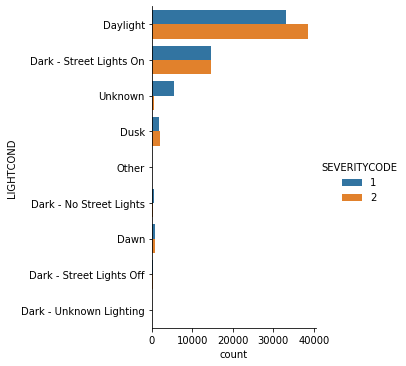

In [7]:
sns.catplot(y='LIGHTCOND', hue='SEVERITYCODE', kind='count',data=df_balanced)
plt.show()

It looks like there isn't much to work with here. Daylight seems to be skewed more towards high severity but since the only lighting condition which is primarily low severity is UNKNOWN we can't derive any valuable insights from this data feature.

Next we'll explore the weather and road conditions to look for correlations to crash severity.

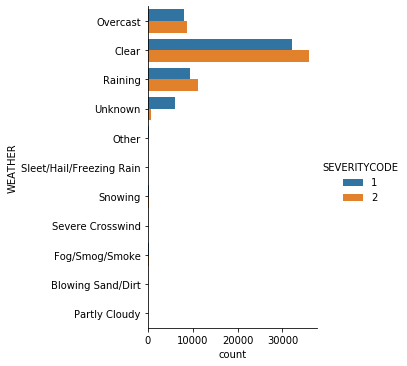

In [8]:
feature = 'WEATHER'
sns.catplot(y=feature, hue='SEVERITYCODE',kind='count' , data=df_balanced[['SEVERITYCODE', feature]])
plt.show()

Again for weather we see a similar issue with UNKNOWN data making up the majority of low severity crashes. And therefore cannot provide any actionable insights. If we choose not to include the UNKNOWNS we might end up skewing our model more to high severity predictions.

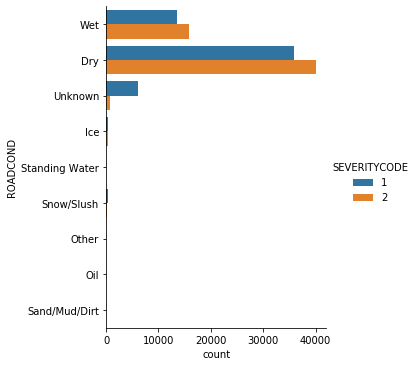

In [9]:
feature = 'ROADCOND'
sns.catplot(y=feature, hue='SEVERITYCODE',kind='count' , data=df_balanced[['SEVERITYCODE', feature]])
plt.show()

This problem of unknowns persists through all the features that we'd like to predict on. The other details of crashes are not features that are easy to know before a crash occurs. Such as innattention, hitting a parked car and collision type. 

Some features such as Speeding and UnderInfluence could be cross-referenced with dates/locations where speeding/driving under influence are more likely to help allocated EMT services for quicker response times. While these questions may provide valuable insights it is not relevant to a day-to-day allocation of EMTs for budgeting/speed of response. This is because speeding/dui behaviors are typically occuring more frequently during holidays and only predicting a few days of the year is low yield.

We'll assess the data by removing unknowns and also by replacing unknowns with the mode. Both of these methods have reasoning behind them. Dropping unknowns would be supported by the fact unknowns don't provide valuable interpretable information. The reason to fill them is that the graphs above them show that there is some serious predictive power located in them so we may not be able to afford losing them. Thus we can fill back assuming that the data was collected similarly to the most common value. 

In [10]:
df_dropped = df.copy(deep=True)
df_dropped = df_dropped[df.ROADCOND != 'Unknown']
df_dropped = df_dropped[df.WEATHER != 'Unknown']
df_dropped = df_dropped[df.LIGHTCOND != 'Unknown']

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [11]:
df_dropped.SEVERITYCODE.value_counts()

1    118788
2     56983
Name: SEVERITYCODE, dtype: int64

In [12]:
df_dropped = undersample(df_dropped, 'SEVERITYCODE')
df_dropped.SEVERITYCODE.value_counts()

2    56983
1    56983
Name: SEVERITYCODE, dtype: int64

We've now removed the low value datapoints and we can evaluate the usefulness of the desired features in WEATHER, ROADCOND, AND LIGHTCOND

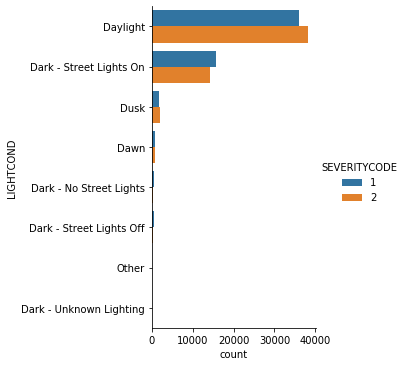

In [13]:
sns.catplot(y='LIGHTCOND', hue='SEVERITYCODE', kind='count',data=df_dropped)
plt.show()

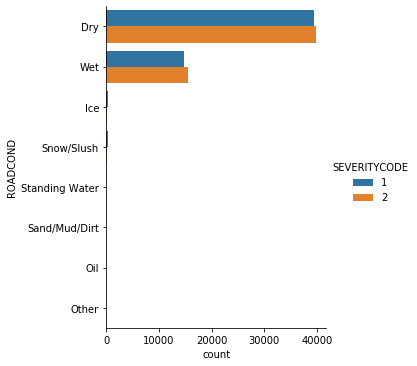

In [14]:
sns.catplot(y='ROADCOND', hue='SEVERITYCODE', kind='count',data=df_dropped)
plt.show()

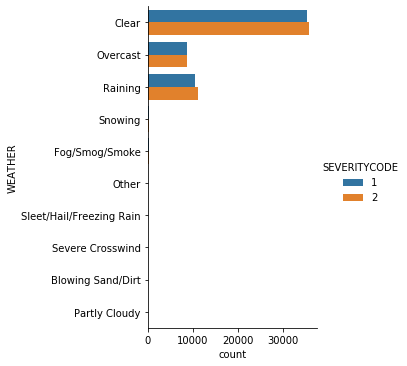

In [15]:
sns.catplot(y='WEATHER', hue='SEVERITYCODE', kind='count',data=df_dropped)
plt.show()

The second option for dealing with unknowns is to replace them with the mode data value. Using a fill option instead of dropping them. In this case we'll be replacing as follows 

 - LIGHTCOND -> "Daylight"
 - WEATHER -> "Clear"
 - ROADCOND -> "Dry"

In [79]:
df_replace = df_balanced.copy(deep=True)
df_replace.LIGHTCOND.replace('Unknown','Daylight', inplace=True)
df_replace.WEATHER.replace('Unknown','Clear', inplace=True)
df_replace.ROADCOND.replace('Unknown','Dry', inplace=True)

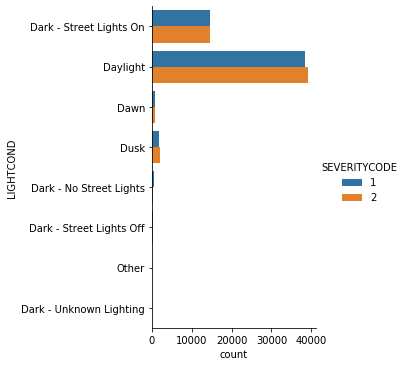

In [80]:
sns.catplot(y='LIGHTCOND', hue='SEVERITYCODE', kind='count',data=df_replace)
plt.show()

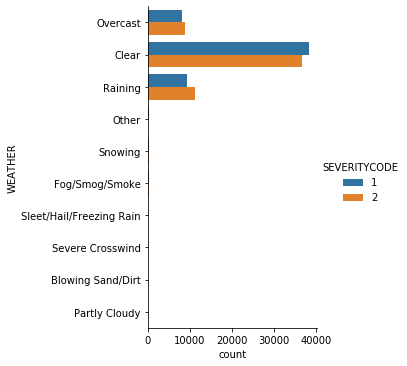

In [81]:
sns.catplot(y='WEATHER', hue='SEVERITYCODE', kind='count',data=df_replace)
plt.show()

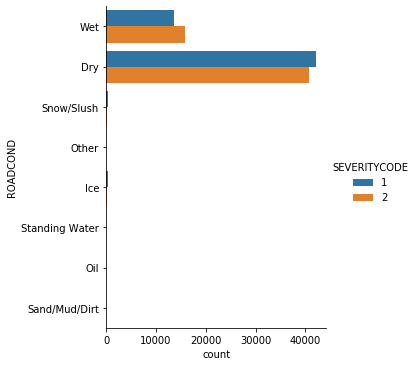

In [82]:
sns.catplot(y='ROADCOND', hue='SEVERITYCODE', kind='count',data=df_replace)
plt.show()

### DATA PREPARATION + FEATURE CREATION

Its very clear that dropping the unknowns creates a large gap in the data and thus moving forward we'll be using the data from df_replace which converted "Unknown" to the most common data value.

We can start prepping this data to be ready for the model. We'll use one-hot encoding for the ADDRTYPE feature and change LIGHTCOND into a binary 0s = Dark, 1 = Daylight. since those are the two primary categories we see and they effects on crash severity are in-line with those simplified categories. 

We aren't quite done with data exploration though. I'd like to investigate feature interactions between WEATHER, LIGHTCOND and ROADCND. Its possible that these features have a higher impact on crash severity prediction in combination than alone. We'll determine this by a one-hot encoding and multiplication between the most common features.

In [83]:
# one-hot encoding for addrTYPE
addrtype = pd.get_dummies(df_replace['ADDRTYPE'])
addrtype.head()

,Alley,Block,Intersection
75990,0,1,0
87185,0,1,0
132402,0,1,0
59348,0,1,0
125907,0,1,0


In [84]:
# mapping LIGHTCOND to 1 = Daylight 0 = Dark. 
# Consider Dawn and Dusk as Dark.

d = {
    'Daylight': 1, 
    'Dark - Street Lights On': 0, 
    'Dawn': 0, 
    'Dusk': 0,
    'Dark - No Street Lights': 0, 
    'Dark - Street Lights Off': 0, 
    'Other': 0,
    'Dark - Unknown Lighting': 0,
    0: 0
}
df_replace.LIGHTCOND.fillna(0, inplace=True)
df_replace.LIGHTCOND = df_replace['LIGHTCOND'].apply(lambda x: d[x])

In [85]:
pd.get_dummies(df_replace[['WEATHER','ROADCOND']]).sum()

WEATHER_Blowing Sand/Dirt              36
WEATHER_Clear                       74844
WEATHER_Fog/Smog/Smoke                354
WEATHER_Other                         423
WEATHER_Overcast                    16813
WEATHER_Partly Cloudy                   4
WEATHER_Raining                     20586
WEATHER_Severe Crosswind               13
WEATHER_Sleet/Hail/Freezing Rain       64
WEATHER_Snowing                       490
ROADCOND_Dry                        82935
ROADCOND_Ice                          667
ROADCOND_Oil                           37
ROADCOND_Other                         74
ROADCOND_Sand/Mud/Dirt                 47
ROADCOND_Snow/Slush                   531
ROADCOND_Standing Water                67
ROADCOND_Wet                        29308
dtype: int64

In [86]:
keep = [
    'WEATHER_Clear', 'WEATHER_Overcast', 'WEATHER_Raining', 'WEATHER_Fog/Smog/Smoke', 'WEATHER_Snowing',
    'ROADCOND_Dry', 'ROADCOND_Wet', 'ROADCOND_Ice', 'ROADCOND_Snow/Slush'
]
weather_road = pd.get_dummies(df_replace[['WEATHER','ROADCOND']])[keep]
weather_road.head()

,WEATHER_Clear,WEATHER_Overcast,WEATHER_Raining,WEATHER_Fog/Smog/Smoke,WEATHER_Snowing,ROADCOND_Dry,ROADCOND_Wet,ROADCOND_Ice,ROADCOND_Snow/Slush
75990,0,1,0,0,0,0,1,0,0
87185,1,0,0,0,0,1,0,0,0
132402,1,0,0,0,0,1,0,0,0
59348,1,0,0,0,0,1,0,0,0
125907,1,0,0,0,0,1,0,0,0


In [87]:
df_prep = addrtype.merge(weather_road, left_index=True, right_index=True)
df_prep = df_prep.merge(df_replace[['LIGHTCOND','SEVERITYCODE']], left_index=True, right_index=True)
df_prep.head()

,Alley,Block,Intersection,WEATHER_Clear,WEATHER_Overcast,WEATHER_Raining,WEATHER_Fog/Smog/Smoke,WEATHER_Snowing,ROADCOND_Dry,ROADCOND_Wet,ROADCOND_Ice,ROADCOND_Snow/Slush,LIGHTCOND,SEVERITYCODE
75990,0,1,0,0,1,0,0,0,0,1,0,0,0,1
87185,0,1,0,1,0,0,0,0,1,0,0,0,0,1
132402,0,1,0,1,0,0,0,0,1,0,0,0,1,1
59348,0,1,0,1,0,0,0,0,1,0,0,0,1,1
125907,0,1,0,1,0,0,0,0,1,0,0,0,1,1


In [88]:
#sanity check with correlation and lightcondition visualization
df_prep.corr()['SEVERITYCODE']

Alley                    -0.030665
Block                    -0.197414
Intersection              0.211665
WEATHER_Clear            -0.027478
WEATHER_Overcast          0.016547
WEATHER_Raining           0.039769
WEATHER_Fog/Smog/Smoke    0.003121
WEATHER_Snowing          -0.019640
ROADCOND_Dry             -0.024856
ROADCOND_Wet              0.043591
ROADCOND_Ice             -0.013773
ROADCOND_Snow/Slush      -0.025118
LIGHTCOND                 0.011744
SEVERITYCODE              1.000000
Name: SEVERITYCODE, dtype: float64

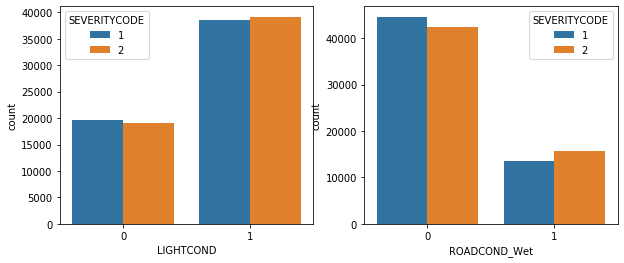

In [89]:
f,axes = plt.subplots(1,2, figsize=(10,4))
sns.countplot(x=df_prep['LIGHTCOND'], hue=df_prep['SEVERITYCODE'], ax=axes[0])
sns.countplot(x=df_prep['ROADCOND_Wet'], hue=df_prep['SEVERITYCODE'], ax=axes[1])

plt.show()

In [90]:
#creating feature interactions
weather = ['WEATHER_Clear', 'WEATHER_Overcast', 'WEATHER_Raining', 'WEATHER_Fog/Smog/Smoke', 'WEATHER_Snowing']
roadcond = ['ROADCOND_Dry', 'ROADCOND_Wet', 'ROADCOND_Ice', 'ROADCOND_Snow/Slush']
ints = pd.DataFrame(df_prep['SEVERITYCODE'])
for w in weather:
    for rc in roadcond:
        interaction = (df_prep[w]) * (df_prep[rc])
        interaction = interaction.rename(w+"_"+rc)
        ints = ints.merge(interaction, left_index=True, right_index=True)
ints.head()    

,SEVERITYCODE,WEATHER_Clear_ROADCOND_Dry,WEATHER_Clear_ROADCOND_Wet,WEATHER_Clear_ROADCOND_Ice,WEATHER_Clear_ROADCOND_Snow/Slush,WEATHER_Overcast_ROADCOND_Dry,WEATHER_Overcast_ROADCOND_Wet,WEATHER_Overcast_ROADCOND_Ice,WEATHER_Overcast_ROADCOND_Snow/Slush,WEATHER_Raining_ROADCOND_Dry,...,WEATHER_Raining_ROADCOND_Ice,WEATHER_Raining_ROADCOND_Snow/Slush,WEATHER_Fog/Smog/Smoke_ROADCOND_Dry,WEATHER_Fog/Smog/Smoke_ROADCOND_Wet,WEATHER_Fog/Smog/Smoke_ROADCOND_Ice,WEATHER_Fog/Smog/Smoke_ROADCOND_Snow/Slush,WEATHER_Snowing_ROADCOND_Dry,WEATHER_Snowing_ROADCOND_Wet,WEATHER_Snowing_ROADCOND_Ice,WEATHER_Snowing_ROADCOND_Snow/Slush
75990,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
87185,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
132402,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59348,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
125907,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
ints.corr()['SEVERITYCODE'].sort_values()

WEATHER_Clear_ROADCOND_Dry                   -2.722263e-02
WEATHER_Snowing_ROADCOND_Snow/Slush          -1.853733e-02
WEATHER_Overcast_ROADCOND_Snow/Slush         -1.295311e-02
WEATHER_Clear_ROADCOND_Snow/Slush            -1.233581e-02
WEATHER_Snowing_ROADCOND_Ice                 -1.201609e-02
WEATHER_Clear_ROADCOND_Ice                   -8.494438e-03
WEATHER_Overcast_ROADCOND_Ice                -5.939779e-03
WEATHER_Raining_ROADCOND_Snow/Slush          -3.558214e-03
WEATHER_Fog/Smog/Smoke_ROADCOND_Wet          -1.161498e-03
WEATHER_Snowing_ROADCOND_Wet                 -8.932741e-04
WEATHER_Snowing_ROADCOND_Dry                  3.473367e-16
WEATHER_Raining_ROADCOND_Ice                  8.838783e-04
WEATHER_Raining_ROADCOND_Dry                  1.589491e-03
WEATHER_Fog/Smog/Smoke_ROADCOND_Ice           3.056450e-03
WEATHER_Fog/Smog/Smoke_ROADCOND_Dry           3.497834e-03
WEATHER_Clear_ROADCOND_Wet                    6.208698e-03
WEATHER_Overcast_ROADCOND_Dry                 1.170592e-

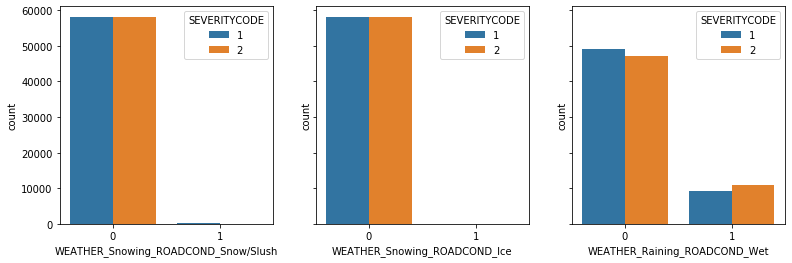

In [94]:
f,axes = plt.subplots(1,3, figsize=(13,4), sharey=True)
sns.countplot(x=ints['WEATHER_Snowing_ROADCOND_Snow/Slush'], hue=ints['SEVERITYCODE'], ax=axes[0])
sns.countplot(x=ints['WEATHER_Snowing_ROADCOND_Ice'], hue=ints['SEVERITYCODE'], ax=axes[1])
sns.countplot(x=ints['WEATHER_Raining_ROADCOND_Wet'], hue=ints['SEVERITYCODE'], ax=axes[2])
plt.show()

The Interactions give us a few more features which can be used to predict. I'm hesitant to include the interaction between Snowing and Road_Ice due to the very low number of cases where both are positive but given its relatively high correlation to severity I'll keep it and make a mental note about it incase we may need to tune the model to improve its predictive strength. 

We've completed the Data Preparation Stage by taking the features with greater then 0.01 correlation. We'll start modelling with LogisticRegressionClassifiers and explore other models if the results are unsatisfactory.

In [95]:
df_final = df_prep.copy(deep=True)
drop = ['WEATHER_Fog/Smog/Smoke']
df_final.drop(drop, axis=1,inplace=True)

keep = ['WEATHER_Snowing_ROADCOND_Snow/Slush', 'WEATHER_Snowing_ROADCOND_Ice', 'WEATHER_Raining_ROADCOND_Wet',
        'WEATHER_Overcast_ROADCOND_Dry', 'WEATHER_Overcast_ROADCOND_Wet', 'WEATHER_Clear_ROADCOND_Snow/Slush',
        'WEATHER_Overcast_ROADCOND_Snow/Slush', 'WEATHER_Clear_ROADCOND_Dry'
       ]
df_final = df_final.merge(ints[keep], right_index=True, left_index=True)

In [96]:
df_final

,Alley,Block,Intersection,WEATHER_Clear,WEATHER_Overcast,WEATHER_Raining,WEATHER_Snowing,ROADCOND_Dry,ROADCOND_Wet,ROADCOND_Ice,...,LIGHTCOND,SEVERITYCODE,WEATHER_Snowing_ROADCOND_Snow/Slush,WEATHER_Snowing_ROADCOND_Ice,WEATHER_Raining_ROADCOND_Wet,WEATHER_Overcast_ROADCOND_Dry,WEATHER_Overcast_ROADCOND_Wet,WEATHER_Clear_ROADCOND_Snow/Slush,WEATHER_Overcast_ROADCOND_Snow/Slush,WEATHER_Clear_ROADCOND_Dry
75990,0,1,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
87185,0,1,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
132402,0,1,0,1,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,0,1
59348,0,1,0,1,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,0,1
125907,0,1,0,1,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194663,0,1,0,0,0,1,0,0,1,0,...,1,2,0,0,1,0,0,0,0,0
194666,0,1,0,1,0,0,0,0,1,0,...,1,2,0,0,0,0,0,0,0,0
194668,0,1,0,1,0,0,0,1,0,0,...,1,2,0,0,0,0,0,0,0,1
194670,0,0,1,1,0,0,0,1,0,0,...,1,2,0,0,0,0,0,0,0,1


In [98]:
df_final.to_csv('data/final_dataset.csv', index=False)

In [99]:
df_final = pd.read_csv("data/final_dataset.csv")

### Modeling + Model Evaluation

We'll start generating models and evaluating them using Precision/Recall for the most part. Given that we are interested in informing Healthcare systems for EMT assignments the primary metric we are looking for is capturing all the high severity crashes. This is because we assume that understaffing EMTs will reduce effective response times as well as necessitate overtime/call-ins for addition EMTs which would be more costly, financially, than having them on staff already.

The first model we will evaluate is a LogisticRegression model.

In [101]:
X = df_final.drop('SEVERITYCODE',axis=1)
y = df_final.SEVERITYCODE
y0 = y.replace(2, 0)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
X_train, X_test, y0_train, y0_test = train_test_split(X, y0, test_size=0.2, random_state=5)

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test), target_names=['Property Damage', 'Injury']))


                 precision    recall  f1-score   support

Property Damage       0.58      0.73      0.65     11662
         Injury       0.64      0.48      0.55     11614

       accuracy                           0.60     23276
      macro avg       0.61      0.60      0.60     23276
   weighted avg       0.61      0.60      0.60     23276



This model isn't too bad but in the category we care the most about "Injury" we aren't capturing enough of the total incidencts with a 0.49 recall. However we are fairly good at correctly predicting them when we do with a 0.62 precision. I'd like to see these much higher before providing this model to any sort of client so I think we'll look into a decision tree and Nearest Neighbors as a quick comparison.


In [104]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=5, criterion='entropy')
clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test), target_names=['Property Damage', 'Injury']))

                 precision    recall  f1-score   support

Property Damage       0.58      0.73      0.65     11662
         Injury       0.64      0.47      0.54     11614

       accuracy                           0.60     23276
      macro avg       0.61      0.60      0.60     23276
   weighted avg       0.61      0.60      0.60     23276



In [105]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=3)

clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test), target_names=['Property Damage', 'Injury']))

                 precision    recall  f1-score   support

Property Damage       0.57      0.68      0.62     11662
         Injury       0.60      0.48      0.53     11614

       accuracy                           0.58     23276
      macro avg       0.58      0.58      0.57     23276
   weighted avg       0.58      0.58      0.57     23276



 
 We'll try tuning the models a little to see if we can increase prediction power a little.

In [106]:
from sklearn.model_selection import GridSearchCV
params = {
    'C': [0.25, 0.5, 1],
    'solver': ['liblinear','lbfgs','newton-cg'],
    'max_iter': [1000]
}

clf = LogisticRegression()
search = GridSearchCV(clf, params, cv=5, scoring='f1_micro').fit(X,y)
print(search.best_params_)
print(classification_report(y_test, search.predict(X_test), target_names=['Property Damage', 'Injury']))

{'C': 0.5, 'max_iter': 1000, 'solver': 'liblinear'}
                 precision    recall  f1-score   support

Property Damage       0.58      0.73      0.65     11662
         Injury       0.64      0.48      0.55     11614

       accuracy                           0.60     23276
      macro avg       0.61      0.60      0.60     23276
   weighted avg       0.61      0.60      0.60     23276



In [107]:
params = {
    'max_features': [1, 3,5, None],
    'criterion': ['gini','entropy']
}

clf = DecisionTreeClassifier()
search = GridSearchCV(clf, params, cv=5, scoring='f1_micro').fit(X,y)
print(search.best_params_)
print(classification_report(y_test, search.predict(X_test), target_names=['Property Damage', 'Injury']))

{'criterion': 'gini', 'max_features': 3}
                 precision    recall  f1-score   support

Property Damage       0.58      0.73      0.65     11662
         Injury       0.64      0.47      0.55     11614

       accuracy                           0.60     23276
      macro avg       0.61      0.60      0.60     23276
   weighted avg       0.61      0.60      0.60     23276



In [109]:
params = {
    'n_neighbors': [3, 5, 7],
}

clf = KNeighborsClassifier()
search = GridSearchCV(clf, params, cv=5, scoring='f1_micro').fit(X,y)
print(search.best_params_)
print(classification_report(y_test, search.predict(X_test), target_names=['Property Damage', 'Injury']))

{'n_neighbors': 7}
                 precision    recall  f1-score   support

Property Damage       0.50      1.00      0.67     11662
         Injury       0.65      0.00      0.00     11614

       accuracy                           0.50     23276
      macro avg       0.58      0.50      0.33     23276
   weighted avg       0.58      0.50      0.34     23276



Parameter tuning isn't having the desired effect so the last thing I'd like to try to improve the model is to be even more strict with the features we are using. And drop anything with less than 0.02 correlation.

In [110]:
df_final.corr()['SEVERITYCODE']

Alley                                  -0.030665
Block                                  -0.197414
Intersection                            0.211665
WEATHER_Clear                          -0.027478
WEATHER_Overcast                        0.016547
WEATHER_Raining                         0.039769
WEATHER_Snowing                        -0.019640
ROADCOND_Dry                           -0.024856
ROADCOND_Wet                            0.043591
ROADCOND_Ice                           -0.013773
ROADCOND_Snow/Slush                    -0.025118
LIGHTCOND                               0.011744
SEVERITYCODE                            1.000000
WEATHER_Snowing_ROADCOND_Snow/Slush    -0.018537
WEATHER_Snowing_ROADCOND_Ice           -0.012016
WEATHER_Raining_ROADCOND_Wet            0.040022
WEATHER_Overcast_ROADCOND_Dry           0.011706
WEATHER_Overcast_ROADCOND_Wet           0.013184
WEATHER_Clear_ROADCOND_Snow/Slush      -0.012336
WEATHER_Overcast_ROADCOND_Snow/Slush   -0.012953
WEATHER_Clear_ROADCO

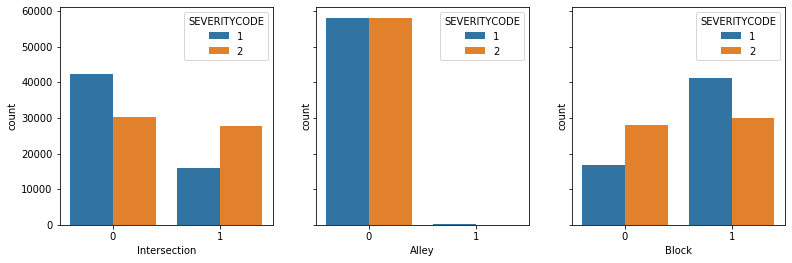

In [119]:
f,axes = plt.subplots(1,3, figsize=(13,4), sharey=True)
sns.countplot(x=df_final['Intersection'], hue=df_final['SEVERITYCODE'], ax=axes[0])
sns.countplot(x=df_final['Alley'], hue=df_final['SEVERITYCODE'], ax=axes[1])
sns.countplot(x=df_final['Block'], hue=df_final['SEVERITYCODE'], ax=axes[2])
plt.show()

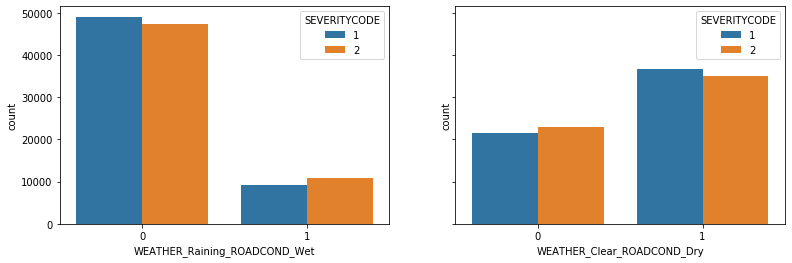

In [121]:
f,axes = plt.subplots(1,2, figsize=(13,4), sharey=True)
sns.countplot(x=df_final['WEATHER_Raining_ROADCOND_Wet'], hue=df_final['SEVERITYCODE'], ax=axes[0])
sns.countplot(x=df_final['WEATHER_Clear_ROADCOND_Dry'], hue=df_final['SEVERITYCODE'], ax=axes[1])
plt.show()

In [116]:
# ,'WEATHER_Raining','ROADCOND_Wet','ROADCOND_Ice'
# ,'Alley','Block','Intersection'
# X = df_final.drop(['SEVERITYCODE','Alley','Block', 'Intersection',
#                    'WEATHER_Raining','ROADCOND_Wet','ROADCOND_Ice','WEATHER_Snowing_ROADCOND_Ice',
#                    'WEATHER_Raining_ROADCOND_Wet'], axis=1)

X = df_final.drop(['SEVERITYCODE',
                   'WEATHER_Overcast','WEATHER_Snowing','ROADCOND_Ice','LIGHTCOND',
                   'WEATHER_Snowing_ROADCOND_Snow/Slush','WEATHER_Snowing_ROADCOND_Ice',
                   'WEATHER_Overcast_ROADCOND_Dry','WEATHER_Overcast_ROADCOND_Wet',
                   'WEATHER_Clear_ROADCOND_Snow/Slush','WEATHER_Overcast_ROADCOND_Snow/Slush'], axis=1)

y = df_final['SEVERITYCODE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [122]:
clf = LogisticRegression(C=0.25, max_iter=1000, solver='liblinear')
clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test), target_names=['Property Damage', 'Injury']))

                 precision    recall  f1-score   support

Property Damage       0.58      0.73      0.65     11662
         Injury       0.64      0.48      0.55     11614

       accuracy                           0.60     23276
      macro avg       0.61      0.60      0.60     23276
   weighted avg       0.61      0.60      0.60     23276



In [113]:
df_final.sum

Alley                                      363
Block                                    71380
Intersection                             43709
WEATHER_Clear                            74844
WEATHER_Overcast                         16813
WEATHER_Raining                          20586
WEATHER_Snowing                            490
ROADCOND_Dry                             82935
ROADCOND_Wet                             29308
ROADCOND_Ice                               667
ROADCOND_Snow/Slush                        531
LIGHTCOND                                77654
SEVERITYCODE                            174564
WEATHER_Snowing_ROADCOND_Snow/Slush        287
WEATHER_Snowing_ROADCOND_Ice                86
WEATHER_Raining_ROADCOND_Wet             20026
WEATHER_Overcast_ROADCOND_Dry            10012
WEATHER_Overcast_ROADCOND_Wet             6566
WEATHER_Clear_ROADCOND_Snow/Slush           95
WEATHER_Overcast_ROADCOND_Snow/Slush        74
WEATHER_Clear_ROADCOND_Dry               71812
dtype: int64

By removing low impact weather effects and the location types of alley,block,intersection we were able to improve our recall for "injury" cases but it reduced our precision. This has its own trade offs but seems like a worse option than before due to the severely hampered prediction power for "Property Damage" cases. 

###  CONCLUSION

Our efforts to imrpove our model were unsuccessful which brings us to the conclusion that more data must be acquired in order to move forward. This is especially apparent considering that many of our high correlation features are binary with less than 5% of the total datapoints being "True". 

When this problem is revisted along with collecting a larger dataset we could consider adding/using additional features. Some of these would include location (are there high severity crash hotspots), and time of crash (is there a more dangerous time to drive?). Both of these could improve our model as well being relevant to the use case of locating and shift assignment of EMTs.
